## Handwritten Digit Recognition - MNIST Dataset - CNN - Python/Keras

In [1]:
from keras.datasets import mnist
from keras import layers, models
import matplotlib.pyplot as plt
from keras.utils import to_categorical
import numpy as np
import tensorflow as tf

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [3]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)
train_images , test_images = train_images / 255.0 , test_images / 255.0

In [4]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,1)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64, (3,3), activation = 'relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation = 'relu'))
model.add(layers.Dense(10, activation = 'softmax'))
# model_cnn.summary()
model.compile(optimizer='rmsprop',loss='sparse_categorical_crossentropy',metrics=['accuracy']) #98.97 - adam 99.23 - rmsprop
model.fit(train_images, train_labels, epochs = 5, batch_size = 60,validation_data=(test_images, test_labels)) 
test_loss, test_acc = model.evaluate(test_images, test_labels)
print('Test accuracy:', (test_acc*100))




Epoch 1/5


1000/1000 [==============================] - 6s 6ms/step - loss: 0.1492 - accuracy: 0.9535 - val_loss: 0.0471 - val_accuracy: 0.9846
Epoch 2/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0456 - accuracy: 0.9859 - val_loss: 0.0349 - val_accuracy: 0.9883
Epoch 3/5
1000/1000 [==============================] - 5s 5ms/step - loss: 0.0307 - accuracy: 0.9904 - val_loss: 0.0298 - val_accuracy: 0.9894
Epoch 4/5
1000/1000 [==============================] - 10s 10ms/step - loss: 0.0227 - accuracy: 0.9932 - val_loss: 0.0276 - val_accuracy: 0.9924
Epoch 5/5
313/313 [==============================] - 1s 2ms/step - loss: 0.0319 - accuracy: 0.9909
Test accuracy: 99.08999800682068


In [5]:
def generate_adversarial_example(input_image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = tf.sign(data_grad)
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = (input_image + (epsilon * sign_data_grad)).numpy()
    # Clip the perturbed image to be within [0, 1]
    perturbed_image = tf.clip_by_value(perturbed_image, 0, 1)
    return perturbed_image

In [42]:
# FGSM attack
def fgsm_attack(model,image, label):
    image = tf.cast(image, tf.float32)
    # Record gradients of the loss with respect to the input image
    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image)
        loss = tf.keras.losses.sparse_categorical_crossentropy(label, prediction)
    # Get the gradients of the loss with respect to the input image
    gradient = tape.gradient(loss, image)
    # Generate adversarial example using FGSM
    perturbed_image = generate_adversarial_example(image, 0.2, gradient)
    return perturbed_image

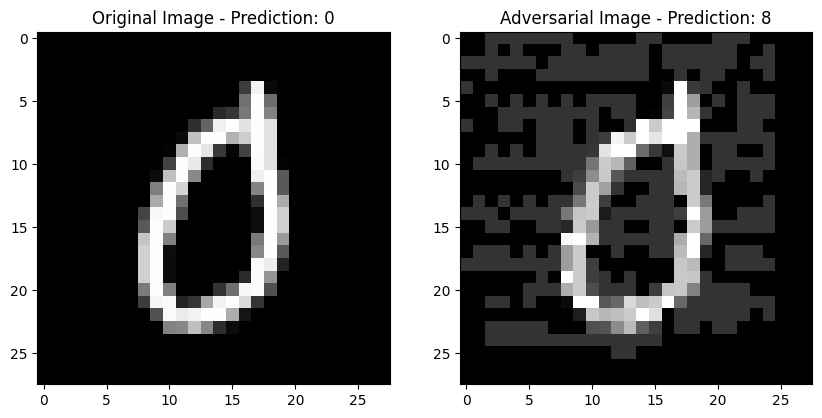

In [46]:
# Select a random image from the test set
idx = np.random.randint(0, len(test_images))
test_image = test_images[idx].reshape(1, 28, 28, 1)
true_label = test_labels[idx]

# Generate adversarial example
perturbed_image = fgsm_attack(model,test_image, true_label)

# Predictions before and after attack
prediction_before_attack = model(test_image).numpy().argmax()
prediction_after_attack = model(perturbed_image).numpy().argmax()

# Plot original and adversarial images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(test_image[0], cmap='gray')
plt.title(f'Original Image - Prediction: {prediction_before_attack}')
plt.subplot(1, 2, 2)
plt.imshow(perturbed_image[0], cmap='gray')
plt.title(f'Adversarial Image - Prediction: {prediction_after_attack}')
plt.show()